## Model Training and Interpretability

In [60]:
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import graphviz

In [2]:
from Statistical_Modeling import load_data, preprocess_data, split_data, visualize_data, train_and_evaluate_models, visualize_tree_model, interpret_model_with_shap


In [3]:
path = '/content/cleaned_dataset.csv'
df = load_data(path)

/content/Statistical_Modeling.py:19: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [4]:
# visualize_data(df)
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [5]:
processed_df = preprocess_data(df)

In [6]:
# Step 3: Split data
target_column = "TotalClaims"
X_train, X_test, y_train, y_test = split_data(processed_df, target_column)

In [7]:
# Step 4: Train and evaluate models
results, feature_importances, models = train_and_evaluate_models(X_train, X_test, y_train, y_test)

Training Linear Regression...
Linear Regression Results: MSE=0.8530407026678306, MAE=0.06394708330554745, R2=0.007749861884026932

Training Random Forest...
Random Forest Results: MSE=1.0781060355083187, MAE=0.056012753455157875, R2=-0.25404433726458264

Training XGBoost...
XGBoost Results: MSE=0.9492499359959213, MAE=0.06126030819409471, R2=-0.1041599505777624



In [8]:
# Print results
print("Model Performance:")
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics}")

Model Performance:
Linear Regression: {'MSE': 0.8530407026678306, 'MAE': 0.06394708330554745, 'R2': 0.007749861884026932}
Random Forest: {'MSE': 1.0781060355083187, 'MAE': 0.056012753455157875, 'R2': -0.25404433726458264}
XGBoost: {'MSE': 0.9492499359959213, 'MAE': 0.06126030819409471, 'R2': -0.1041599505777624}


In [62]:
from Statistical_Modeling import load_data, preprocess_data, split_data, visualize_data, train_and_evaluate_models, visualize_tree_model, interpret_model_with_shap
from sklearn.tree import export_graphviz  # Import the function


def visualize_tree_model(model, feature_names, tree_index=0):
    """Visualizes a decision tree from a tree-based model."""
    if hasattr(model, "estimators_"):  # RandomForestRegressor
        estimator = model.estimators_[tree_index]
        dot_data = export_graphviz(
            estimator,
            out_file=None,
            feature_names=feature_names,
            filled=True,
            rounded=True,
            special_characters=True
        )
        graph = graphviz.Source(dot_data)
        return graph
    else:
        print("This model does not support tree visualization.")


In [63]:
# Visualize a tree from Random Forest
graph = visualize_tree_model(models["Random Forest"], X_train.columns, tree_index=0)
graph.render("random_forest_tree", format="png", cleanup=True)  # Save the tree as an image
graph.view()  # Display the tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.138232 to fit


'random_forest_tree.pdf'

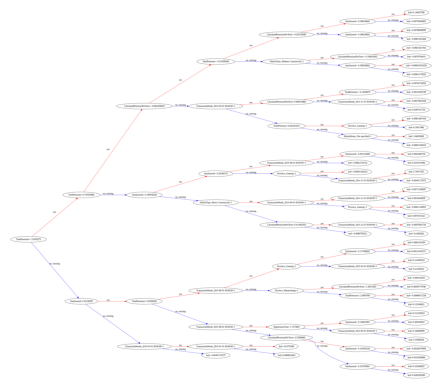

In [13]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Visualize the first tree in the XGBoost model
plot_tree(models["XGBoost"], num_trees=0, rankdir='LR')
plt.show()

### Model Interpretation with SHAP

100%|===================| 799594/800078 [19:22<00:00]       

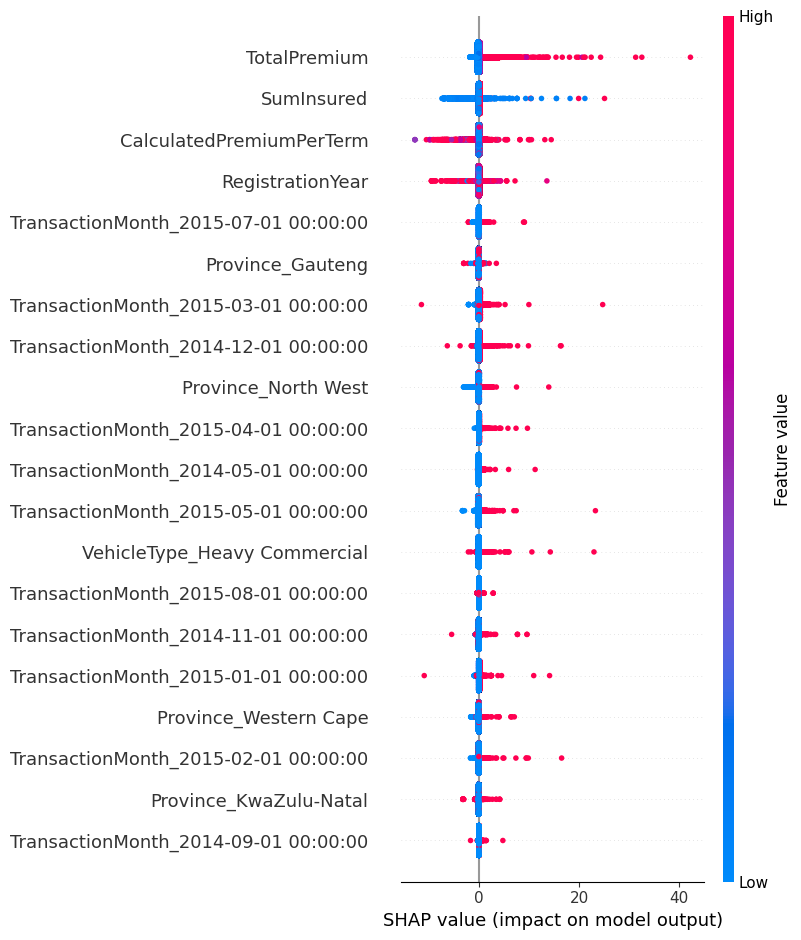

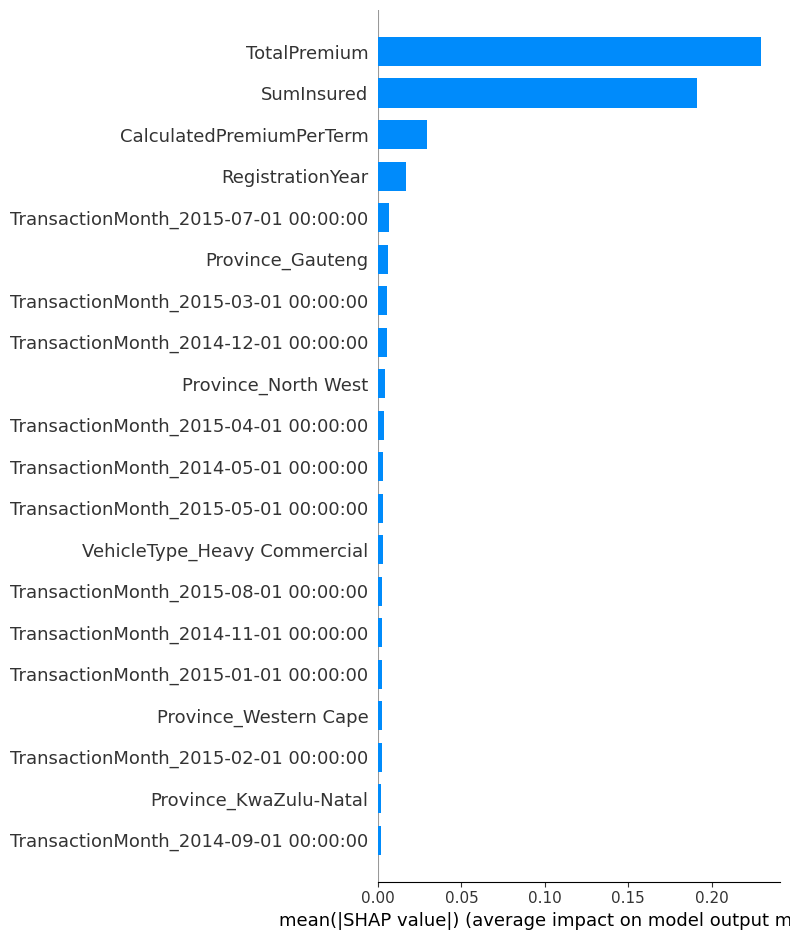

In [14]:
# Interpret model with SHAP
interpret_model_with_shap(models["XGBoost"], X_train)

In [45]:
def interpret_model_with_lime(model, X_train, X_test, feature_names, instance_index=0):

    # Initialize the LIME explainer
    explainer = LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=feature_names,
        class_names=['regression'],  # Adjust for classification or regression
        mode='regression'  # Change to 'classification' for classification tasks
    )

    # Select an instance from the test set
    instance = np.array(X_test.iloc[instance_index])

    # Generate explanations for the selected instance
    explanation = explainer.explain_instance(
        data_row=instance,
        predict_fn=model.predict
    )

    # Visualize the explanation
    explanation.show_in_notebook(show_table=True)
    return explanation


In [56]:
# Feature names should match your dataset
feature_names = X_train.columns.tolist()


print ("With instance_index TotalPremium")
explanation = interpret_model_with_lime(
    model=models["XGBoost"],
    X_train=X_train,
    X_test=X_test,
    feature_names=feature_names,
    instance_index=3
)


With instance_index TotalPremium


In [54]:
# Print the explanation details
print("LIME Explanation for the Observation:")
lime_explanation = explanation.as_list()
print(lime_explanation)

LIME Explanation for the Observation:
[('TransactionMonth_2014-10-01 00:00:00 <= 0.00', -1.2550762702385545), ('TotalPremium <= -0.27', -0.8262231131107599), ('Province_Free State <= 0.00', -0.7862422495472845), ('TransactionMonth_2014-05-01 00:00:00 <= 0.00', -0.7301804360646011), ('TransactionMonth_2014-12-01 00:00:00 <= 0.00', -0.5929264173074469), ('TransactionMonth_2014-04-01 00:00:00 <= 0.00', 0.47998850769323603), ('TransactionMonth_2013-11-01 00:00:00 <= 0.00', 0.4241819809099481), ('TransactionMonth_2015-06-01 00:00:00 <= 0.00', -0.4146747660326695), ('TransactionMonth_2014-02-01 00:00:00 <= 0.00', 0.40935853608558803), ('TransactionMonth_2015-05-01 00:00:00 <= 0.00', -0.3782878175044659)]


In [34]:
list = [1,2,3,26,28,31]
for i in list:
  print(feature_names[i])

SumInsured
CalculatedPremiumPerTerm
TotalPremium
MaritalStatus_Not specified
Gender_Male
Province_Gauteng


In [50]:
# lime_explanation = [('TransactionMonth_2014-12-01 00:00:00 <= 0.00', -0.8213447385442086), ('-0.26 < TotalPremium <= -0.17', -0.7199337380010454), ('TransactionMonth_2014-03-01 00:00:00 <= 0.00', -0.6585035756747983), ('TransactionMonth_2014-10-01 00:00:00 <= 0.00', -0.6113331957624834), ('TransactionMonth_2015-07-01 00:00:00 > 0.00', 0.5522852258794968), ('TransactionMonth_2013-12-01 00:00:00 <= 0.00', 0.5108560503862898), ('Province_Northern Cape <= 0.00', -0.4826236587809574), ('TransactionMonth_2014-02-01 00:00:00 <= 0.00', 0.48010512017482415), ('TransactionMonth_2014-07-01 00:00:00 <= 0.00', -0.40059968483465985), ('TransactionMonth_2014-01-01 00:00:00 <= 0.00', 0.27102493044719134)]

In [55]:
# Create the header row
markdown_table = "| Condition | Contribution to Prediction |\n"
markdown_table += "|---|---| \n"

# Add rows for each LIME explanation item
for condition, contribution in lime_explanation:
    markdown_table += f"| {condition} | {contribution} |\n"

# Print or display the markdown table
print(markdown_table)

| Condition | Contribution to Prediction |
|---|---| 
| TransactionMonth_2014-10-01 00:00:00 <= 0.00 | -1.2550762702385545 |
| TotalPremium <= -0.27 | -0.8262231131107599 |
| Province_Free State <= 0.00 | -0.7862422495472845 |
| TransactionMonth_2014-05-01 00:00:00 <= 0.00 | -0.7301804360646011 |
| TransactionMonth_2014-12-01 00:00:00 <= 0.00 | -0.5929264173074469 |
| TransactionMonth_2014-04-01 00:00:00 <= 0.00 | 0.47998850769323603 |
| TransactionMonth_2013-11-01 00:00:00 <= 0.00 | 0.4241819809099481 |
| TransactionMonth_2015-06-01 00:00:00 <= 0.00 | -0.4146747660326695 |
| TransactionMonth_2014-02-01 00:00:00 <= 0.00 | 0.40935853608558803 |
| TransactionMonth_2015-05-01 00:00:00 <= 0.00 | -0.3782878175044659 |



['RegistrationYear',
 'SumInsured',
 'CalculatedPremiumPerTerm',
 'TotalPremium',
 'TransactionMonth_2013-11-01 00:00:00',
 'TransactionMonth_2013-12-01 00:00:00',
 'TransactionMonth_2014-01-01 00:00:00',
 'TransactionMonth_2014-02-01 00:00:00',
 'TransactionMonth_2014-03-01 00:00:00',
 'TransactionMonth_2014-04-01 00:00:00',
 'TransactionMonth_2014-05-01 00:00:00',
 'TransactionMonth_2014-06-01 00:00:00',
 'TransactionMonth_2014-07-01 00:00:00',
 'TransactionMonth_2014-08-01 00:00:00',
 'TransactionMonth_2014-09-01 00:00:00',
 'TransactionMonth_2014-10-01 00:00:00',
 'TransactionMonth_2014-11-01 00:00:00',
 'TransactionMonth_2014-12-01 00:00:00',
 'TransactionMonth_2015-01-01 00:00:00',
 'TransactionMonth_2015-02-01 00:00:00',
 'TransactionMonth_2015-03-01 00:00:00',
 'TransactionMonth_2015-04-01 00:00:00',
 'TransactionMonth_2015-05-01 00:00:00',
 'TransactionMonth_2015-06-01 00:00:00',
 'TransactionMonth_2015-07-01 00:00:00',
 'TransactionMonth_2015-08-01 00:00:00',
 'MaritalStatus_